In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from dataTransformation import labels4clients, distribute_data_labels4clients
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from utils import Logger
from fid_score import *
from inception import *

In [2]:
NUM_WORKERS = 5
CLASSES_PER_USER = 10
NUM_EPOCHS = 200

LEARNING_RATE = 2e-4
B1 = 0.5
B2 = 0.999
BATCH_SIZE = 64
NOISE_DIM = 128
FID_BATCH_SIZE = 20
NUM_UNIQUE_USERS = NUM_WORKERS

In [3]:
num_classes = 10
logger = Logger(model_name='F2U',data_name='CIFAR10')
dictionary = labels4clients(num_classes,CLASSES_PER_USER,NUM_WORKERS,NUM_UNIQUE_USERS,random_seed=False)
print(dictionary)

{0: [0, 1, 2, 3, 4], 1: [0, 1, 2, 3, 4], 2: [0, 1, 2, 3, 4], 3: [0, 1, 2, 3, 4], 4: [0, 1, 2, 3, 4], 5: [0, 1, 2, 3, 4], 6: [0, 1, 2, 3, 4], 7: [0, 1, 2, 3, 4], 8: [0, 1, 2, 3, 4], 9: [0, 1, 2, 3, 4]}


In [4]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# trans_cifar = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)
dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)
dataloader_one = torch.utils.data.DataLoader(dataset, shuffle = True,batch_size=BATCH_SIZE)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle = True,batch_size=10000)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
for img in dataloader_test:
    test_imgs=img[0].to(dev)

In [6]:
# print(dataset.data[0])
# print(dataset.transforms(dataset.data[0],transforms.ToTensor()))
# print(dataset.transforms(dataset.data[0],trans_cifar))

transformed shape: (3, 32, 32)


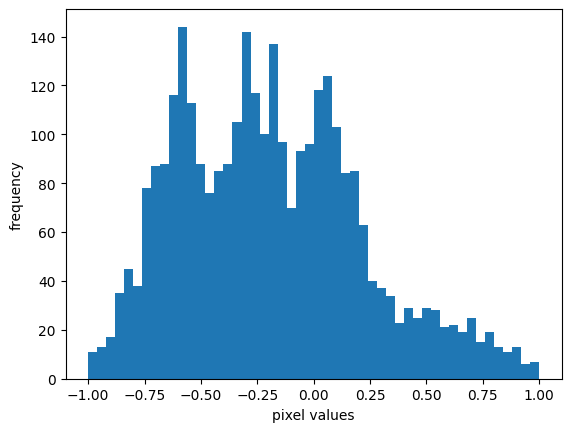

In [7]:
transformed = trans_cifar(dataset.data[0]).cpu().detach().numpy()
print("transformed shape:", transformed.shape)
plt.figure('normalized data')
plt.hist(transformed.ravel(), bins=50, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [8]:
# print(dataset.data.shape)
# print(type(dataset))
# print(dataloader_one.dataset.data.shape)
# x,_ = dataloader_one.dataset[0]
# print(x.shape)
# print(x)

In [9]:
x_train_normalized_np = np.empty((dataset.data.shape[0],dataset.data.shape[3],dataset.data.shape[1],dataset.data.shape[2]))
print("train datatset shape:",x_train_normalized_np.shape)
for i in range(len(dataset)):
    x_train_normalized_np[i] = trans_cifar(dataset.data[i])

train datatset shape: (50000, 3, 32, 32)


In [10]:
x_train_normalized_np[0][0].shape

(32, 32)

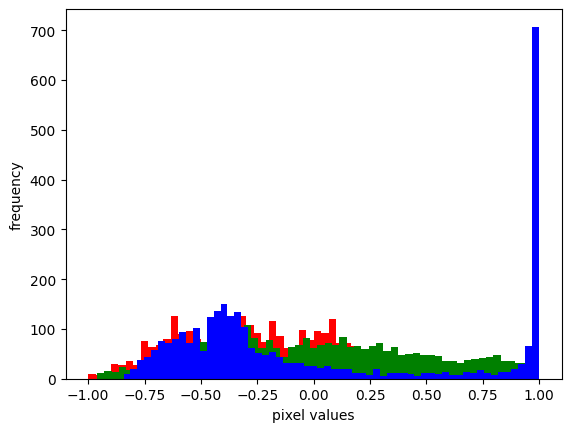

In [11]:
plt.figure('normalized data')
bin_size = 60
plt.hist(x_train_normalized_np[:][0].ravel(),color='r', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][1].ravel(),color='g', bins=bin_size, density=False)
plt.hist(x_train_normalized_np[:][2].ravel(),color='b', bins=bin_size, density=False)
plt.xlabel("pixel values")
plt.ylabel("frequency")
plt.show()

In [12]:
# x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_clinet_list, y_client_list = distribute_data_labels4clients(x_train_normalized_np,y_train,dictionary,False)

In [13]:
def getDist(y,num_classes,user_num):
    ax = sns.countplot(x=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

10000


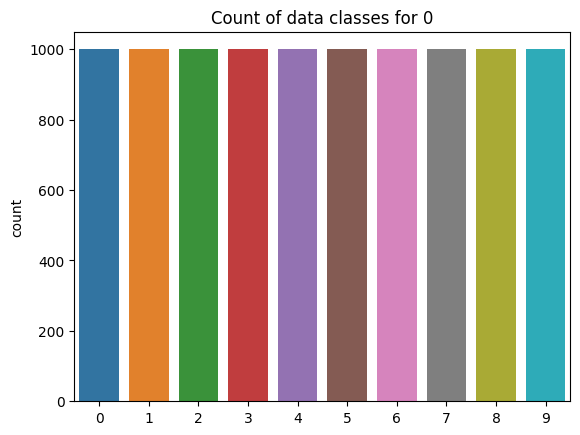

10000


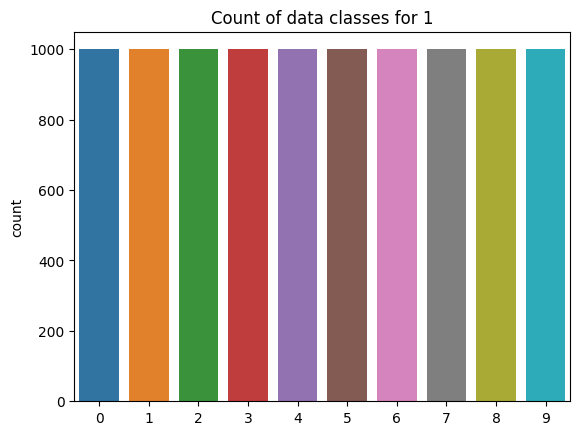

10000


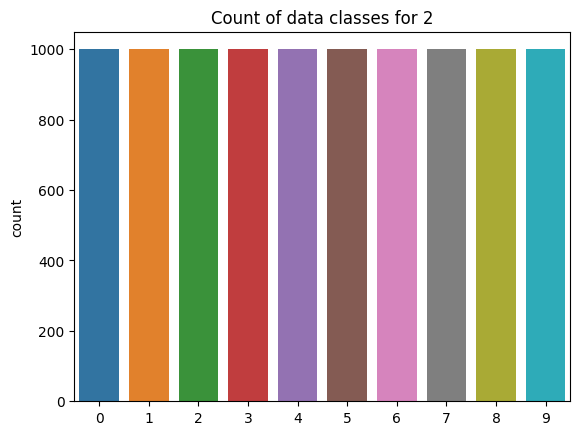

10000


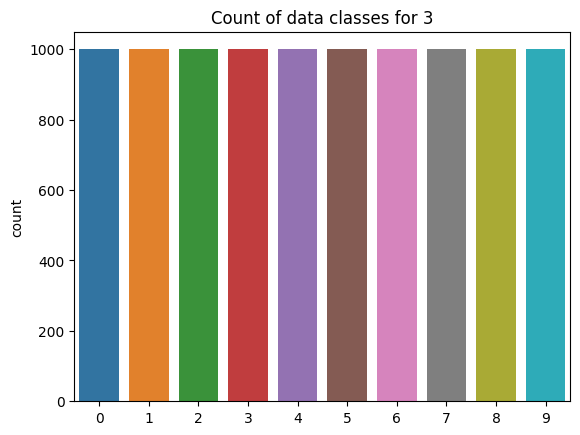

10000


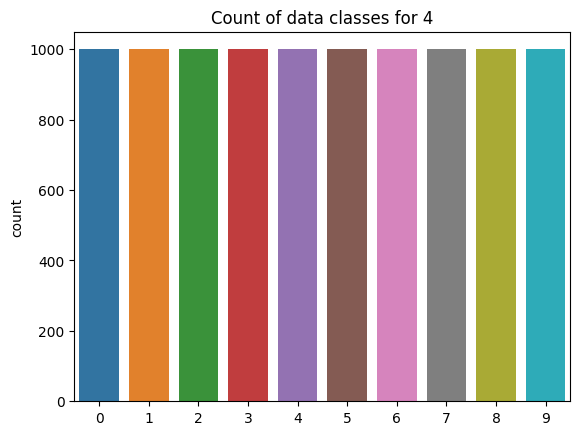

In [14]:
for i in range (len(x_clinet_list)):
    print(len(y_client_list[i]))
    getDist(y_client_list[i],num_classes,i)

In [15]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [16]:
fic_model = InceptionV3().to(dev)

In [17]:
main_server = Server(0,LEARNING_RATE,B1,B2)
main_server.generator.train()
workers = []
for i in range(NUM_WORKERS):
    worker = Worker(i,LEARNING_RATE,B1,B2)
    # x_clinet_list[i] = np.transpose(x_clinet_list[i],(0, 3, 1, 2))
    worker.load_worker_data(x_clinet_list[i], y_client_list[i])
    worker.discriminator.train()
    workers.append(worker)
    
# summary(main_server.generator,(128,1,1))
# summary(workers[0].discriminator,(3,32,32))

In [18]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(36, NOISE_DIM, 1, 1).to(dev)

worker_loaders = []

for worker in workers:
    # print(worker.x_data.shape)
    worker_loaders.append([])
    for batch_id, real in enumerate(DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)):
        worker_loaders[-1].append(real)

In [19]:
trial = True

In [20]:
# GAN archicture trial (trial == TRUE)
if trial:
    start = 0
    end = start + NUM_EPOCHS
    for epoch in range(start,end):
        for i, data in enumerate(dataloader_one):
            worker = workers[0]
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)
            real, _ = data

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            
            current_disc_real = worker.discriminator(real).reshape(-1)
            # print('current discriminator real output', current_disc_real)
            worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
            # print('worker loss_disc_real output', current_disc_real)
            current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
            worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
            worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
            worker.discriminator.zero_grad()
            worker.loss_disc.backward()
            # total_norm_d =0
            # for p in list(filter(lambda p: p.grad is not None, worker.discriminator.parameters())):
            #     total_norm_d += p.grad.detach().data.norm(2).item()** 2
            # total_norm_d = total_norm_d ** 0.5

            worker.d_optimizer.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            
            output = worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            main_server.generator.zero_grad()
            main_server.loss_gen.backward()

            # total_norm_g =0
            # for p in list(filter(lambda p: p.grad is not None, main_server.generator.parameters())):
            #     total_norm_g += p.grad.detach().data.norm(2).item()** 2
            # total_norm_g = total_norm_g ** 0.5

            main_server.g_optimizer.step()


            logger.log(worker.loss_disc.item(),main_server.loss_gen.item(),worker.loss_disc_real, worker.loss_disc_fake,epoch,i,len(dataloader_one))

            # Print loss
            if i % 100 == 0:    
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,i,len(dataloader_one))

                print(
                    f"Epoch [{epoch}/{end}] Batch {i}/{len(dataloader_one)} \
                    Loss D: {worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )

            if i% 500 == 0:
                with torch.no_grad():
                    fake = main_server.generator(fixed_noise)
                    logger.log_images(fake,len(fake), epoch, i, len(dataloader_one))
        if epoch % 50 == 0 and epoch !=0:
            logger.save_models(main_server,workers,epoch)


Epoch [0/200] Batch 0/782                     Loss D: 0.6936, loss G: 0.7498, FID Score: 410.9
Epoch [0/200] Batch 100/782                     Loss D: 0.6693, loss G: 1.5987, FID Score: 336.8
Epoch [0/200] Batch 200/782                     Loss D: 0.7301, loss G: 1.0359, FID Score: 343.4
Epoch [0/200] Batch 300/782                     Loss D: 0.7187, loss G: 0.9712, FID Score: 332.5
Epoch [0/200] Batch 400/782                     Loss D: 0.6832, loss G: 0.7308, FID Score: 361.0
Epoch [0/200] Batch 500/782                     Loss D: 0.6715, loss G: 0.5761, FID Score: 426.0
Epoch [0/200] Batch 600/782                     Loss D: 0.6925, loss G: 0.6760, FID Score: 377.4
Epoch [0/200] Batch 700/782                     Loss D: 0.7110, loss G: 0.7708, FID Score: 348.8
Epoch [1/200] Batch 0/782                     Loss D: 0.6786, loss G: 0.7050, FID Score: 481.7
Epoch [1/200] Batch 100/782                     Loss D: 0.6416, loss G: 1.0002, FID Score: 365.2
Epoch [1/200] Batch 200/782       

In [ ]:
# main training loop for F2U (trial == FALSE)
if not trial:
    start = 0
    end = start + NUM_EPOCHS

    worker_chosen_counter = [0 for i in range(len(workers))]

    for epoch in range(start,end):
        for batch_id in range(len(worker_loaders[0])):

            highest_loss = 0
            chosen_discriminator = None
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)

            for worker_id, worker in enumerate(workers):
                current_worker_real = worker_loaders[worker_id][batch_id].float().to(dev)
                # print(real.shape)

                ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
                current_disc_real = worker.discriminator(current_worker_real).reshape(-1)
                worker.loss_disc_real = criterion(current_disc_real, torch.ones_like(current_disc_real))
                current_disc_fake = worker.discriminator(fake.detach()).reshape(-1)
                worker.loss_disc_fake = criterion(current_disc_fake, torch.zeros_like(current_disc_fake))
                worker.loss_disc = (worker.loss_disc_real + worker.loss_disc_fake) / 2
                worker.discriminator.zero_grad()
                worker.loss_disc.backward()
                worker.d_optimizer.step()
                # print(worker.loss_disc_fake, i)
                if highest_loss < worker.loss_disc_fake:
                    highest_loss = worker.loss_disc_fake
                    chosen_discriminator = worker_id
            # print(f"chosen worker is {chosen_discriminator} with loss of: {highest_loss.item():.4f}")
            chosen_worker = workers[chosen_discriminator]
            worker_chosen_counter[chosen_discriminator]+=1
            

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            output = chosen_worker.discriminator(fake).reshape(-1)
            main_server.loss_gen = criterion(output, torch.ones_like(output))
            main_server.generator.zero_grad()
            main_server.loss_gen.backward()
            main_server.g_optimizer.step()

            logger.log(chosen_worker.loss_disc.item(),main_server.loss_gen.item(),chosen_worker.loss_disc_real, chosen_worker.loss_disc_fake,epoch,batch_id,len(worker_loaders[0]))

            # Print loss
            if batch_id % 100 == 0:
                fid_z = torch.randn(FID_BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
                gen_imgs = main_server.generator(fid_z.detach())
                mu_gen, sigma_gen = calculate_activation_statistics(gen_imgs, fic_model, batch_size=FID_BATCH_SIZE,cuda=True)
                mu_test, sigma_test = calculate_activation_statistics(test_imgs[:FID_BATCH_SIZE], fic_model, batch_size=FID_BATCH_SIZE)
                fid = calculate_frechet_distance(mu_gen, sigma_gen, mu_test, sigma_test)
                logger.log_fid(fid,epoch,batch_id,len(worker_loaders[0]))

                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(worker_loaders[0])} \
                    Loss D: {chosen_worker.loss_disc:.4f}, loss G: {main_server.loss_gen:.4f}, FID Score: {fid:.1f}"
                )
            
        with torch.no_grad():
            fake = main_server.generator(fixed_noise)
            logger.log_images(fake,len(fake), epoch, batch_id, len(worker_loaders[0]))

        if epoch % 5 == 0 and epoch != 0:
            plt.bar(range(len(worker_chosen_counter)),worker_chosen_counter)
            plt.xlabel('worker number')
            plt.ylabel('chosen counter')
            plt.show()
        if epoch % 20 == 0 and epoch != 0:
            logger.save_models(main_server,workers,epoch)